### Grocery Store Access for Seniors in the City of Los Angeles: Prep Notebook
<b>Team:</b> Carolyn Pugh, Lucy Briggs, Monisha Reginald<br><br>
<b>Research Question</b>: Where do gaps in access to grocery stores by non-automobile modes exist for seniors who live in the city of Los Angeles?<br>
<b>Notbook Purpose:</b> This notebook creates dataframes that will be necessary to explore the locations of seniors, senior-headed households without access to a vehicle, grocery stores, and transit stops within the City of Los Angeles.<br><br>
<b>Data Sources:</b>
1. Total Population by Block Group for Los Angeles City [downloaded from Census Reporter](https://censusreporter.org/data/table/?table=B01003&geo_ids=16000US0644000,150|16000US0644000&primary_geo_id=16000US0644000#)
2. Los Angeles City Boundary [imported directly via API from LA GeoHub](https://geohub.lacity.org/maps/city-boundary)
3. Los Angeles Times Neighborhood Boundaries [imported directly via API From LA GeoHub](https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0/explore?location=34.020320%2C-118.410084%2C10.96)
4. ACS 2021 5-Year Estimates [imported directly via API from United States Census Bureau](https://www.census.gov/data/developers/data-sets/acs-5year.html)
5. SNAP Store Locations [imported directly via API from USDA](https://usda-fns.hub.arcgis.com/datasets/USDA-FNS::snap-store-locations/explore?location=14.817317%2C-14.634785%2C2.79)
6. Lucy's Senior Basemap layer (LINK)

In [1]:
# Import basic packages.
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Import packages for plots and maps. 
import matplotlib.pyplot as plt
import contextily as ctx
import plotly.express as px

# Import libraries for doing network analysis with open street map. 
import networkx as nx
import osmnx as ox

#### Part 1: Create Census Block Group Geographies
<b>Output:</b> We will create a geodataframe for all census block groups within the City of Los Angeles that contains spatial information about the block group's boundary and the neighborhood that the largest portion of the block group falls within.

We want a dataframe with the block group boundaries within the City of Los Angeles. To create this dataframe, we will begin by cleaning a file that contains the geometries for all block groups with any portion within the City of Los Angeles. Note that we will be projecting all datasets so that we are able to perform various geoprocessing calculations (including calculating area).

In [2]:
# Import block group geometries and total population for all block groups that have at least some portion within the City of Los Angeles.
bg_proj=gpd.read_file("acs2021_5yr_B01003_15000US060371041082.geojson").to_crs('epsg:6423')

# Create block group identifier from the end of the geoid.
bg_proj['BG20'] = bg_proj['geoid'].str.replace('15000US06037','')

# Keep just columns we need.
bg_proj=bg_proj[['BG20','B01003001','geometry']]

# Rename columns.
bg_proj=bg_proj.rename(columns={'B01003001':'Total_Pop'})

# Sort values so that the BG at end (highest population) represents the entire City of LA, then drop it.
bg_proj=bg_proj.sort_values('Total_Pop')
bg_proj.drop(bg_proj.tail(1).index,inplace=True)

Next, we will "clip" the block group geodataframe to the LA City boundary.

In [3]:
# Import LA City boundary directly from Los Angeles GeoHub. 
cityboundary_proj=gpd.read_file("https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/7/query?outFields=*&where=1%3D1&f=geojson").to_crs('epsg:6423')

# Clip the block group data to the LA city boundary to get just block groups within the City of LA.
bg_la=gpd.clip(bg_proj, cityboundary_proj)

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


We also want to be able to do analysis by neighborhood, so we will next assign each block group to a neighborhood. However, block groups may span several neighborhoods, so we will assign each block group to the neighborhood that contains the largest portion of its area.

<AxesSubplot: >

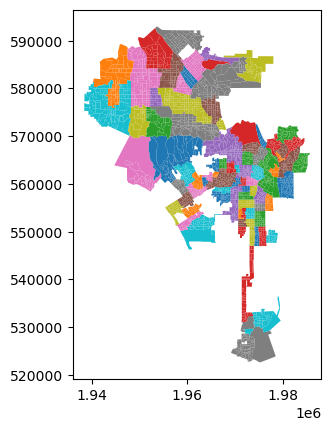

In [4]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})

# Get intersection of each block group and neighborhood and then calculate the area of each of these intersections.
bg_neighborhoods=gpd.overlay(bg_la, neighborhoods, how='intersection', keep_geom_type=False)
bg_neighborhoods['area']=bg_neighborhoods.area

# For each block group, keep just the row that has the largest area (intersection with neighborhood with the largest area)
bg_neighborhoods=bg_neighborhoods.sort_values(by=['BG20','area'],ascending=False).drop_duplicates(
    subset=['BG20'], keep='first').drop(columns=['OBJECTID','geometry','area'])

# Give the census block groups their original boundaries back (rather than the intersection boundaries that currently remain).
bg_neighborhoods=pd.merge(bg_neighborhoods,bg_la[['BG20','geometry']],how='left',on=['BG20']).set_geometry('geometry')

# Quick plot to check that we have retained our block group geometries and that the neighborhoods are correctly assigned.
bg_neighborhoods.plot(column='neighborhood')

We can see that this new geodataframe 1) has block group boundaries, 2) is restricted to the City of Los Angeles, and 3) has a "neighborhood" column that appropriately categorizes the rows. We will save this geojson, which will be useful for analyses.

In [5]:
bg_neighborhoods.to_file('bg_geometries.geojson')

#### Part 2: Create Geodataframe of Vehicle Access by Block Group
<b>Output:</b> We will create a geodataframe that contains information about vehicle access by age for all block groups in the City of Los Angeles.

We use the Census API to pull in demographic data related to household vehicle ownership by age for all block groups in LA County. We only want block groups in City of LA, but that isn't a supported geographical heirarchy, so we'll have to pull in a larger set and filter later on.

In [6]:
# Set up parameters of API request (variables of interest within ACS 2021 5-Year Estimates for all Block Groups in Los Angeles County)
import requests
apirequest = 'https://api.census.gov/data/2021/acs/acs5?get=NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E&for=block%20group:*&in=state:06%20county:037'
usr_key = f"&key=4c422219a890d0597a042d9ebad9311b022cfd4d"
# Use requests package to get data via API request.
response = requests.get(f"{apirequest}{usr_key}")

We have to convert this API response to a dataframe that we can work with in Python.

In [7]:
# We have to create a dataframe from the original response converted to json.
census_df=pd.DataFrame(response.json())

# Now we can take a look at the data in Python.
census_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E,state,county,tract,block group
1,"Block Group 1, Census Tract 1011.10, Los Angel...",40,0,299,53,44,0,212,60,06,037,101110,1
2,"Block Group 2, Census Tract 1011.10, Los Angel...",28,28,236,90,62,42,234,53,06,037,101110,2
3,"Block Group 3, Census Tract 1011.10, Los Angel...",0,0,247,74,18,18,74,0,06,037,101110,3
4,"Block Group 1, Census Tract 1011.22, Los Angel...",9,0,593,223,0,0,184,0,06,037,101122,1


We notice that the variable names are in the first row of the dataframe, so we move the variable names from row 0 to the column headers.

In [8]:
# Rename columns with data in row 0.
census_df.columns = census_df.iloc[0]

# Now drop row 0 now that column names have been successfully extracted.
census_df = census_df.iloc[1:].reset_index().drop(columns=['index'])

# Check that column names have been updated.
census_df.head()

,NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E,state,county,tract,block group
0,"Block Group 1, Census Tract 1011.10, Los Angel...",40,0,299,53,44,0,212,60,06,037,101110,1
1,"Block Group 2, Census Tract 1011.10, Los Angel...",28,28,236,90,62,42,234,53,06,037,101110,2
2,"Block Group 3, Census Tract 1011.10, Los Angel...",0,0,247,74,18,18,74,0,06,037,101110,3
3,"Block Group 1, Census Tract 1011.22, Los Angel...",9,0,593,223,0,0,184,0,06,037,101122,1
4,"Block Group 2, Census Tract 1011.22, Los Angel...",0,0,426,136,0,0,160,0,06,037,101122,2


We will now clean our dataset so that it contains just columns that we need and those columns have clear labels.

In [9]:
# Rename census variable names and drop unnessaray variables.
census_df=census_df.rename(columns={'B25045_003E':'Owner no vehicle', 'B25045_006E':'Owner no vehicle 65+',
                         'B25045_007E':'Owner with vehicle', 'B25045_010E' : 'Owner with vehicle 65+',
                         'B25045_012E' : 'Renter no vehicle', 'B25045_015E' : 'Renter no vehicle 65+',
                         'B25045_016E' : 'Renter with vehicle', 'B25045_019E' : 'Renter with vehicle 65+'},).drop(columns=['NAME','state','county'])

# Check that this worked. 
census_df.head()

,Owner no vehicle,Owner no vehicle 65+,Owner with vehicle,Owner with vehicle 65+,Renter no vehicle,Renter no vehicle 65+,Renter with vehicle,Renter with vehicle 65+,tract,block group
0,40,0,299,53,44,0,212,60,101110,1
1,28,28,236,90,62,42,234,53,101110,2
2,0,0,247,74,18,18,74,0,101110,3
3,9,0,593,223,0,0,184,0,101122,1
4,0,0,426,136,0,0,160,0,101122,2


Now, we'll join our census data to the block group geometries. To be able to join these datasets together, I will create an appropriate key in my census data by concatenating the census tract and block group numbers to create a unique identified (BG20) that matches the block group geographies.

In [10]:
# Concatenate tract and block group numbers.
census_df['BG20']=census_df['tract']+census_df['block group']

# Drop the separated tract and block group columns, which are no longer necessary.
census_df=census_df.drop(columns=['tract','block group'])
census_df.head()

,Owner no vehicle,Owner no vehicle 65+,Owner with vehicle,Owner with vehicle 65+,Renter no vehicle,Renter no vehicle 65+,Renter with vehicle,Renter with vehicle 65+,BG20
0,40,0,299,53,44,0,212,60,1011101
1,28,28,236,90,62,42,234,53,1011102
2,0,0,247,74,18,18,74,0,1011103
3,9,0,593,223,0,0,184,0,1011221
4,0,0,426,136,0,0,160,0,1011222


We join the census data to the block group geometries, so that each block group has the appropriate spatial and demographic data.

In [11]:
# Left join census_clean data onto the block group geometries.
census_la=pd.merge(bg_neighborhoods, census_df, how="left", on=["BG20"])
census_la.head()

,BG20,Total_Pop,neighborhood,geometry,Owner no vehicle,Owner no vehicle 65+,Owner with vehicle,Owner with vehicle 65+,Renter no vehicle,Renter no vehicle 65+,Renter with vehicle,Renter with vehicle 65+
0,9800391,0.0,Toluca Lake,"MULTIPOLYGON (((1966685.678 571125.893, 196670...",0,0,0,0,0,0,0,0
1,9800311,1160.0,San Pedro,"POLYGON ((1973083.310 528189.940, 1973083.328 ...",0,0,0,0,0,0,10,0
2,9800281,0.0,Westchester,"POLYGON ((1958524.051 550029.553, 1958525.458 ...",0,0,0,0,0,0,0,0
3,9800261,16.0,Tujunga,"POLYGON ((1967614.398 586716.846, 1967615.058 ...",0,0,0,0,0,0,0,0
4,9800241,200.0,Sepulveda Basin,"POLYGON ((1952205.353 576098.621, 1952205.387 ...",0,0,67,10,5,5,10,5


We now have a geodataframe for just the block groups within the city of Los Angeles that contains all of the spatial and demographic data needed for some analysis. Finally, we will create calculated columns (e.g. % of senior-headed households that have a vehicle) to use in analysis.

In [12]:
# Cast numeric data that was originally imported as a string as an integers so they can be used in calculations.
census_clean=census_la.astype({'Owner no vehicle':'int', 'Owner no vehicle 65+':'int', 'Owner with vehicle':'int', 'Owner with vehicle 65+': 'int', 
                                  'Renter no vehicle':'int', 'Renter no vehicle 65+' : 'int', 'Renter with vehicle' : 'int' , 'Renter with vehicle 65+' : 'int'})

# Calculate necesarry sums.
census_clean['Total HH']=census_clean['Owner no vehicle']+census_clean['Owner with vehicle']+census_clean['Renter no vehicle']+census_clean['Renter with vehicle']
census_clean['Senior HH']=census_clean['Owner no vehicle 65+']+census_clean['Owner with vehicle 65+']+census_clean['Renter no vehicle 65+']+census_clean['Renter with vehicle 65+']
census_clean['Total No Vehicle']=census_clean['Owner no vehicle']+census_clean['Renter no vehicle']
census_clean['Senior No Vehicle']=census_clean['Owner no vehicle 65+']+census_clean['Renter no vehicle 65+']

# Drop columns I don't need anymore now that calculations are done.
census_clean=census_clean.drop(columns=['Owner no vehicle', 'Owner no vehicle 65+', 'Owner with vehicle', 'Owner with vehicle 65+', 
                                        'Renter no vehicle', 'Renter no vehicle 65+', 'Renter with vehicle', 'Renter with vehicle 65+'])

# Calculate percentages.
census_clean['Pct Households Without a Vehicle'] = census_clean['Total No Vehicle']/census_clean['Total HH']*100
census_clean['Pct Senior-Headed Households Without a Vehicle']= census_clean['Senior No Vehicle']/census_clean['Senior HH']*100

# Check that this worked.
census_clean.head()

,BG20,Total_Pop,neighborhood,geometry,Total HH,Senior HH,Total No Vehicle,Senior No Vehicle,Pct Households Without a Vehicle,Pct Senior-Headed Households Without a Vehicle
0,9800391,0.0,Toluca Lake,"MULTIPOLYGON (((1966685.678 571125.893, 196670...",0,0,0,0,NaN,NaN
1,9800311,1160.0,San Pedro,"POLYGON ((1973083.310 528189.940, 1973083.328 ...",10,0,0,0,0.000000,NaN
2,9800281,0.0,Westchester,"POLYGON ((1958524.051 550029.553, 1958525.458 ...",0,0,0,0,NaN,NaN
3,9800261,16.0,Tujunga,"POLYGON ((1967614.398 586716.846, 1967615.058 ...",0,0,0,0,NaN,NaN
4,9800241,200.0,Sepulveda Basin,"POLYGON ((1952205.353 576098.621, 1952205.387 ...",82,20,5,5,6.097561,25.0


Now that we have finished our vehicle access geodataframe, we will safe it for use in other subsequent analysis.

In [13]:
census_clean.to_file('vehicle_access.geojson')

#### Part 3: Create Grocery Store Locations
<b>Output:</b> We will create a geodataframe that contains the locations of all chain grocery stores within 1 mile of the City of Los Angeles by cleaning data published by the USDA on the locations of authorized SNAP retailers. In addition to point locations, this geodataframe will include information about which chain the location is part of, what price range the chain falls into, and what neighborhood the chain is located within. 

To identify the locations of grocery stores, we are using data published by the USDA on the locations of authorized SNAP retailers. I will access this data directly by API, which is a particularly important use of APIs because the dataset is refreshed regularly.

In [14]:
# Import data via API.
grocery_snap = gpd.read_file("https://services1.arcgis.com/RLQu0rK7h4kbsBq5/arcgis/rest/services/Store_Locations/FeatureServer/0/query?where=State%20%3D%20'CA'&outFields=*&outSR=4326&f=json").to_crs('epsg:6423')

# Look at basic data structure.
grocery_snap.head()

,Store_Name,Address,Address_Line__2,City,State,Zip5,Zip4,County,Longitude,Latitude,ObjectId,geometry
0,7-ELEVEN STORE 23169B,1075 S Fairfax Ave,None,Los Angeles,CA,90019,4402,LOS ANGELES,-118.36487,34.056053,13,POINT (1966313.957 561741.895)
1,RALPHS 291,4760 W Pico Blvd,None,Los Angeles,CA,90019,4235,LOS ANGELES,-118.33961,34.048386,14,POINT (1968643.164 560883.282)
2,Okay Liquor,5500 W Pico Blvd,None,Los Angeles,CA,90019,3916,LOS ANGELES,-118.35797,34.049026,15,POINT (1966948.210 560960.154)
3,ROSIE'S DISCOUNT STORE,1851 Arlington Ave,None,Los Angeles,CA,90019,6225,LOS ANGELES,-118.31779,34.040390,16,POINT (1970655.035 559989.758)
4,Pinchers Liquor,5121 W Pico Blvd,None,Los Angeles,CA,90019,4133,LOS ANGELES,-118.35003,34.048077,17,POINT (1967680.950 560852.307)


This file contains data for the entire state and we're only interested in the City of Los Angeles. We only want grocery stores that serve the City of Los Angeles. However, since some grocery stores may be right over the municipal boundary (particularly in places like Santa Monica), we will include all grocery stores that are within 1 mile of the City. First, we create a new geodataframe that contains the area within 1 mile of the City of Los Angeles.

<AxesSubplot: >

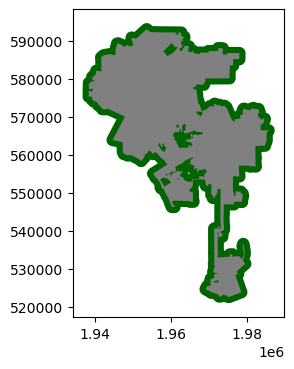

In [15]:
# Create a polygon with 1 mile buffer around municipal boundary. 
la_extended=cityboundary_proj.buffer(1609.34)

# Quick plot to make sure this loooks right.
fig,ax = plt.subplots(figsize=(4,4))
cityboundary_proj.plot(ax=ax, zorder=2, color='grey')
la_extended.plot(ax=ax, zorder=1, color='darkgreen')

In [16]:
#Create a new geodataframe made up of the grocery store points, clipped to the "mask" of the city boundary.
snap_la = gpd.clip(grocery_snap, la_extended)

We now have all SNAP retailers within or around Los Angeles. However, we must solve two additional problems - many locations that do not provide access to healthy food (e.g. convenient stores, gas station markets, etc.) accept EBT. Additionally, the store's names include store number identifiers (e.g., Ralphs #101), which makes it difficult to analyze trends. To solve these problems, we chose to focus on only chain supermarkets. We will assign each chain supermarket its chain name, and then create a geodataframe with just these stores.

In [17]:
#Create snap_clean with just columns that we will need.
snap_clean=snap_la.drop(columns=['Address', 'Address_Line__2', 'City', 'State', 'Zip5', 'Zip4', 'County', 'ObjectId'])

#Set the strings to be all lower case to minimize the number of variations on the same name that we have to search for.
snap_clean['Store_Name']=snap_clean['Store_Name'].str.lower()

#Define name of new variable.
snap_clean['chain_name']='unknown'

#Set a new value for chain_name if Store_Name contains a specified substring. Note that this list is not exhaustive and will be added to throughout the project. 
snap_clean.loc[snap_clean['Store_Name'].str.contains('albertsons'), 'chain_name'] = 'Albertsons'
snap_clean.loc[snap_clean['Store_Name'].str.contains("albertson's"), 'chain_name'] = 'Albertsons'
snap_clean.loc[snap_clean['Store_Name'].str.contains("aldi"), 'chain_name'] = 'Aldi'
snap_clean.loc[snap_clean['Store_Name'].str.contains("amazon"), 'chain_name'] = 'Amazon Fresh'
snap_clean.loc[snap_clean['Store_Name'] == "amazon go (bowser) ils2", 'chain_name'] = "unknown"
snap_clean.loc[snap_clean['Store_Name'].str.contains("bristol farms"), 'chain_name'] = 'Bristol Farms'
snap_clean.loc[snap_clean['Store_Name'].str.contains("costco"), 'chain_name'] = 'Costco'
snap_clean.loc[snap_clean['Store_Name'].str.contains("garibaldi"), 'chain_name'] = 'unknown'
snap_clean.loc[snap_clean['Store_Name'].str.contains('el super'), 'chain_name'] = 'El Super'
snap_clean.loc[snap_clean['Store_Name'].str.contains('erewhon'), 'chain_name'] = 'Erewhon'
snap_clean.loc[snap_clean['Store_Name'].str.contains('food 4 less'), 'chain_name'] = 'Food 4 Less'
snap_clean.loc[snap_clean['Store_Name'].str.contains("food for less"), 'chain_name'] = 'Food 4 Less'
snap_clean.loc[snap_clean['Store_Name'].str.contains("gelson's market"), 'chain_name'] = "Gelson's"
snap_clean.loc[snap_clean['Store_Name'].str.contains("gelsons market"), 'chain_name'] = "Gelson's"
snap_clean.loc[snap_clean['Store_Name'].str.contains("h mart"), 'chain_name'] = "H Mart"
snap_clean.loc[snap_clean['Store_Name'] == "bh mart", 'chain_name'] = "unknown"
snap_clean.loc[snap_clean['Store_Name'] == "venice beach mart", 'chain_name'] = "unknown"
snap_clean.loc[snap_clean['Store_Name'].str.contains("jons market"), 'chain_name'] = "JONS"
snap_clean.loc[snap_clean['Store_Name'].str.contains("mother's nutritional center"), 'chain_name'] = "Mother's Nutritional Center"
snap_clean.loc[snap_clean['Store_Name'].str.contains("northgate market"), 'chain_name'] = "Northgate Market"
snap_clean.loc[snap_clean['Store_Name'].str.contains("numero uno market"), 'chain_name'] = "Numero Uno Market"
snap_clean.loc[snap_clean['Store_Name'].str.contains("ralphs"), 'chain_name'] = 'Ralphs'
snap_clean.loc[snap_clean['Store_Name'].str.contains("ralph's"), 'chain_name'] = 'Ralphs'
snap_clean.loc[snap_clean['Store_Name'].str.contains("pavilions"), 'chain_name'] = 'Pavilions'
snap_clean.loc[snap_clean['Store_Name'].str.contains("seafood city supermarket"), 'chain_name'] = 'Seafood City Supermarket'
snap_clean.loc[snap_clean['Store_Name'].str.contains("smart & final"), 'chain_name'] = 'Smart & Final'
snap_clean.loc[snap_clean['Store_Name'].str.contains("smart and final"), 'chain_name'] = 'Smart & Final'
snap_clean.loc[snap_clean['Store_Name'].str.contains("sprouts"), 'chain_name'] = 'Sprouts'
snap_clean.loc[snap_clean['Store_Name'].str.contains("superior grocers"), 'chain_name'] = 'Superior Grocers'
snap_clean.loc[snap_clean['Store_Name'].str.contains("super king market"), 'chain_name'] = 'Super King Market'
snap_clean.loc[snap_clean['Store_Name'].str.contains("target"), 'chain_name'] = "Target"
snap_clean.loc[snap_clean['Store_Name'].str.contains("trader joe's"), 'chain_name'] = "Trader Joe's"
snap_clean.loc[snap_clean['Store_Name'].str.contains("trader joes"), 'chain_name'] = "Trader Joe's"
snap_clean.loc[snap_clean['Store_Name'].str.contains("vallarta supermarket"), 'chain_name'] = 'Vallarta Spermarkets'
snap_clean.loc[snap_clean['Store_Name'].str.contains("supermercado vallarta"), 'chain_name'] = 'Vallarta Spermarkets'
snap_clean.loc[snap_clean['Store_Name'].str.contains("vons"), 'chain_name'] = 'Vons'
snap_clean.loc[snap_clean['Store_Name'].str.contains("walmart"), 'chain_name'] = 'Walmart'
snap_clean.loc[snap_clean['Store_Name'].str.contains("whole foods"), 'chain_name'] = 'Whole Foods'
snap_clean

,Store_Name,Longitude,Latitude,geometry,chain_name
19115,7 eleven store 38548 a,-118.32290,33.789879,POINT (1970093.911 532203.719),unknown
10579,lomita farmers market,-118.31984,33.804939,POINT (1970382.634 533873.340),unknown
23482,silver skate liquor & mart,-118.30788,33.808262,POINT (1971491.262 534238.485),unknown
12477,zubeda's mini market 1,-118.29789,33.813122,POINT (1972417.900 534774.791),unknown
6180,cvs 10022,-118.29846,33.813328,POINT (1972365.191 534797.798),unknown
...,...,...,...,...,...
6651,7-eleven 32709,-118.55647,34.274147,POINT (1948758.867 586014.139),unknown
6624,ralphs fresh fare 127,-118.56394,34.274868,POINT (1948071.467 586097.946),Ralphs
6650,whole foods market 10695,-118.55493,34.274925,POINT (1948901.149 586099.651),Whole Foods
6652,cvs pharmacy 9533,-118.56523,34.274879,POINT (1947952.690 586099.834),unknown


To analyze trends by price range, we will also categorize each chain into a chain "type".

In [18]:
snap_clean['chain_type']='unknown'
# Standard chain. 
snap_clean.loc[snap_clean['chain_name'] == "Ralphs", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Trader Joe's", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Vons", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Numero Uno Market", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "JONS", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "El Super", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Albertsons", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Amazon Fresh", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Pavilions", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Super King Market", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Aldi", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Vallarta Spermarkets", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Superior Grocers", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Northgate Market", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Seafood City Supermarket", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "H Mart", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
# Description uses words 'bulk,' 'discount,' or 'vouchers'
snap_clean.loc[snap_clean['chain_name'] == "Smart & Final", 'chain_type'] = "Discount (e.g. Smart & Final, Food 4 Less)"
snap_clean.loc[snap_clean['chain_name'] == "Food 4 Less", 'chain_type'] = "Discount (e.g. Smart & Final, Food 4 Less)"
snap_clean.loc[snap_clean['chain_name'] == "Mother's Nutritional Center", 'chain_type'] = "Discount (e.g. Smart & Final, Food 4 Less)"
snap_clean.loc[snap_clean['chain_name'] == "Costco", 'chain_type'] = "Discount (e.g. Smart & Final, Food 4 Less)"
# Description uses words 'organic' or 'gourmet'
snap_clean.loc[snap_clean['chain_name'] == "Whole Foods", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
snap_clean.loc[snap_clean['chain_name'] == "Gelson's", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
snap_clean.loc[snap_clean['chain_name'] == "Sprouts", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
snap_clean.loc[snap_clean['chain_name'] == "Bristol Farms", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
snap_clean.loc[snap_clean['chain_name'] == "Erewhon", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
# Department stores. 
snap_clean.loc[snap_clean['chain_name'] == "Target", 'chain_type'] = "Department store (e.g. Target, Walmart)"
snap_clean.loc[snap_clean['chain_name'] == "Walmart", 'chain_type'] = "Department store (e.g. Target, Walmart)"

We may want to come back to some of these non-chains to identify which provide fresh and healthy food options at a later time. To facilitate this manual process, we'll begin deleting locations that we know will not qualify.

In [19]:
#Define name of new variable.
snap_clean['location_type']='unknown'

#Label places that are unwanted chains.
snap_clean.loc[snap_clean['Store_Name'].str.contains("7-eleven"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("7 eleven"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("7eleven"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("store #63233"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("store #68540"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("big lots"), 'location_type'] = 'Non-grocery chain'

#Label places that are liquor stores. 
snap_clean.loc[snap_clean['Store_Name'].str.contains("liquor"), 'location_type'] = 'Liquor Store'
snap_clean.loc[snap_clean['Store_Name'].str.contains("wine"), 'location_type'] = 'Liquor Store'
snap_clean.loc[snap_clean['Store_Name'].str.contains("beer"), 'location_type'] = 'Liquor Store'

#Label places that are pharmacies. 
snap_clean.loc[snap_clean['Store_Name'].str.contains("cvs"), 'location_type'] = 'Pharmacy (e.g. CVS, Walgreens, Rite Aid)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("rite aid"), 'location_type'] = 'Pharmacy (e.g. CVS, Walgreens, Rite Aid)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("walgreens"), 'location_type'] = 'Pharmacy (e.g. CVS, Walgreens, Rite Aid)'

#Label places that are small gas station marts.
snap_clean.loc[snap_clean['Store_Name'].str.contains("chevron"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("circle k"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("g&m"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("arco"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("rocket"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("speedway"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("united pacific"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("store #68539"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'] == "arcoiris 98 cents store", 'location_type'] = 'unknown'
snap_clean.loc[snap_clean['Store_Name'] == "larco37", 'chain_name'] = 'location_type'
snap_clean.loc[snap_clean['Store_Name'] == "tortilleria san marcos", 'location_type'] = 'unknown'
snap_clean.loc[snap_clean['Store_Name'].str.contains("h & s energy products"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'

#Label places that are dollar stores.
snap_clean.loc[snap_clean['Store_Name'].str.contains("99 cents only"), 'location_type'] = 'Dollar store (e.g. 99 Cents Only, Dollar Tree)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("99 cent only"), 'location_type'] = 'Dollar store (e.g. 99 Cents Only, Dollar Tree)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("dollar tree"), 'location_type'] = 'Dollar store (e.g. 99 Cents Only, Dollar Tree)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("family dollar"), 'location_type'] = 'Dollar store (e.g. 99 Cents Only, Dollar Tree)'

# Drop columns identified above.
snap_clean = snap_clean.loc[snap_clean['location_type']!='Non-grocery chain'].copy()
snap_clean = snap_clean.loc[snap_clean['location_type']!='Liquor Store']
snap_clean = snap_clean.loc[snap_clean['location_type']!='Pharmacy (e.g. CVS, Walgreens, Rite Aid)']
snap_clean = snap_clean.loc[snap_clean['location_type']!='Gas station (e.g. Chevron, Circle K, G&M Oil)']
snap_clean = snap_clean.loc[snap_clean['location_type']!='Dollar store (e.g. 99 Cents Only, Dollar Tree)']

# Delete column used for this procedure.
snap_clean=snap_clean.drop(columns=['location_type'])
snap_clean.head()

,Store_Name,Longitude,Latitude,geometry,chain_name,chain_type
10579,lomita farmers market,-118.31984,33.804939,POINT (1970382.634 533873.340),unknown,unknown
12477,zubeda's mini market 1,-118.29789,33.813122,POINT (1972417.900 534774.791),unknown,unknown
22282,makkah market,-118.30885,33.818081,POINT (1971404.790 535327.929),unknown,unknown
9300,point fermin market,-118.28802,33.709332,POINT (1973298.787 523259.179),unknown,unknown
5947,beach city market,-118.28799,33.718460,POINT (1973304.469 524271.705),unknown,unknown


Now, we will create a new "clean" geodataframe that has just the grocery stores that have been assigned to a known chain.

In [20]:
#Create new geodataframe that contains all rows assigned to a known supermarket chain.
grocery_chains = snap_clean.loc[snap_clean['chain_name']!='unknown'].copy().reset_index().drop(columns=['index'])
grocery_chains.head()

,Store_Name,Longitude,Latitude,geometry,chain_name,chain_type
0,vons 2162,-118.31068,33.721760,POINT (1971202.334 524644.024),Vons,"Standard chain (e.g. Ralphs, Trader Joe's)"
1,smart & final 923,-118.31312,33.723164,POINT (1970976.651 524800.466),Smart & Final,"Discount (e.g. Smart & Final, Food 4 Less)"
2,vons 2283,-118.29240,33.732872,POINT (1972900.331 525871.550),Vons,"Standard chain (e.g. Ralphs, Trader Joe's)"
3,numero uno market - san pedro 121,-118.29841,33.743370,POINT (1972346.783 527037.685),Numero Uno Market,"Standard chain (e.g. Ralphs, Trader Joe's)"
4,numero uno market 106,-118.28788,33.739361,POINT (1973321.306 526590.138),Numero Uno Market,"Standard chain (e.g. Ralphs, Trader Joe's)"


Finally, we will add in information about which neighborhood each grocery store falls within so that we can conduct analysis about how grocery stores are distributed across neighborhoods.

In [21]:
# Add information about the neighborhood to the geodataframe of locations that I have labeled as chain grocery store chains.
chain_with_neighborhood=grocery_chains.sjoin(neighborhoods, how='left').drop(columns = ['index_right','OBJECTID'])

# Two of the geometries intersect the neighborhood boundaries so they have to be manually reassigned.
chain_with_neighborhood.loc[chain_with_neighborhood['Store_Name'] == 'smart & final 363', 'neighborhood'] = 'Hollywood'
chain_with_neighborhood.loc[chain_with_neighborhood['Store_Name'] == 'costco 1205', 'neighborhood'] = 'Woodland Hills'

# Drop the duplicated stores that we manually reassigned above.
chain_with_neighborhood=chain_with_neighborhood.drop_duplicates(subset=['Store_Name','geometry'], keep='first').reset_index().drop(columns=['index'])

# See how it looks.
chain_with_neighborhood.head()

,Store_Name,Longitude,Latitude,geometry,chain_name,chain_type,neighborhood
0,vons 2162,-118.31068,33.721760,POINT (1971202.334 524644.024),Vons,"Standard chain (e.g. Ralphs, Trader Joe's)",San Pedro
1,smart & final 923,-118.31312,33.723164,POINT (1970976.651 524800.466),Smart & Final,"Discount (e.g. Smart & Final, Food 4 Less)",San Pedro
2,vons 2283,-118.29240,33.732872,POINT (1972900.331 525871.550),Vons,"Standard chain (e.g. Ralphs, Trader Joe's)",San Pedro
3,numero uno market - san pedro 121,-118.29841,33.743370,POINT (1972346.783 527037.685),Numero Uno Market,"Standard chain (e.g. Ralphs, Trader Joe's)",San Pedro
4,numero uno market 106,-118.28788,33.739361,POINT (1973321.306 526590.138),Numero Uno Market,"Standard chain (e.g. Ralphs, Trader Joe's)",San Pedro


<AxesSubplot: >

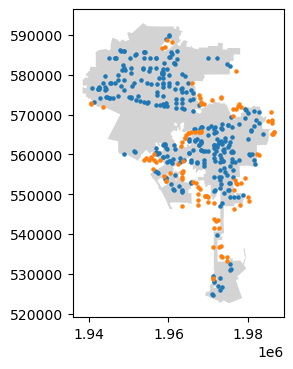

In [22]:
# Quick plot to make sure this loooks right.
fig,ax = plt.subplots(figsize=(4,4))
cityboundary_proj.plot(ax=ax, zorder=1, color='lightgrey')
chain_with_neighborhood[chain_with_neighborhood['neighborhood'].notna()].plot(ax=ax, zorder=2, markersize=5)
chain_with_neighborhood[chain_with_neighborhood['neighborhood'].isna()].plot(ax=ax, zorder=3, markersize=5)

This dataframe looks right - we have just grocery stores within or near Los Angeles. The ones with a neighborhood assigned are all within the municipal boundary, and the points that do not have a neighborhood assigned are bordering the municipal boundary. Finally, we save this geojson for future analysis.

In [23]:
chain_with_neighborhood.to_file('chain_with_neighborhood.geojson')

#### Part 4: Create Grocery Store Walksheds
<b>Output:</b> We will use Network Analysis to create a geodataframe that contains polygons that represent the areas within various walking distances of a grocery store that is located within 1 mile of the CIty of Los Angeles.

First, we will use a for loop to loop through every grocery store and calculate the isochrones that represet various distances along the road network from that starting point. During this loop, we also add these isochrones to a running list of all walksheds (isochrones_all). We will then dissolve this running list by distance, to produce a single polygon for each distance that represents all areas within that distance of a grocery store (e.g., all areas within 285 meters of a grocery store).

In [ ]:
%%time
# Extract x & y coordinates of projection for calculation within loop.
chain_with_neighborhood['geometry_x'], chain_with_neighborhood['geometry_y']=[chain_with_neighborhood.geometry.x,chain_with_neighborhood.geometry.y]

# Create a geodataframe to store isochrones.
isochrones_all = gpd.GeoDataFrame({'walk_distance': [99], 'geometry': [Point(1, 2)]}, crs="EPSG:6423")

# Now, loop through each grocery store to create the isochrones around the grocery store and then append these isochrones to the list.
for index, row in chain_with_neighborhood.iterrows():
    # Download the street network surrounding the grocery store.
    G = ox.graph_from_point([chain_with_neighborhood.loc[index,'Latitude'],chain_with_neighborhood.loc[index,'Longitude']], network_type='walk',  dist = 2000)

    # Project this street network data so that measurements are in meters.
    G = ox.project_graph(G, to_crs='epsg:6423')

    # Convert nodes and edges to geodataframes
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

    # Use osmnx's distance.nearest_nodes command to get the id for the nearest node to the grocery store. 
    center_node = ox.distance.nearest_nodes(G,Y=chain_with_neighborhood.loc[index,'geometry_y'],X=chain_with_neighborhood.loc[index,'geometry_x'])

    # loop through each trip distance.
    for walk_distance in [855,570,285]:

        # For each trip time, create an egograph of nodes that fall within that time
        subgraph = nx.ego_graph(G, center_node, radius=walk_distance, distance='length')

        # For each of those nodes, update the gdf_nodes dataframe and assign it with its associated time
        for node in subgraph.nodes():
                gdf_nodes.loc[node,'walk_distance'] = walk_distance

    # Create polygon containing all nodes within each time (first dissolve then create a convex hull).
    isochrones = gdf_nodes.dissolve(by = "walk_distance").convex_hull.reset_index(name='geometry')
    
    # Append these results to our growing list of isochrones.
    isochrones_all = pd.concat([isochrones_all,isochrones])

# Get rid of temporary columns at index 0.
walkbuffers=isochrones_all.iloc[1:]

# Dissolve separate walksheds to create single geometry with all areas within each time.
walksheds=walkbuffers.dissolve(by = "walk_distance").reset_index().sort_values(by='walk_distance',ascending=False)

Finally, we will clean up this dataframe for mapping by setting a color based on walk distance, and converting the walk distances to walk times. For this analysis we assume that an average senior can walk 58 meters per minute based on [this literature review](https://www.researchgate.net/publication/344166318_Walkability_Index_for_Elderly_Health_A_Proposal).

In [ ]:
# Set colors:
for index, row in walksheds.iterrows():
    if walksheds.loc[index, 'walk_distance']==285:
        walksheds.loc[index, 'colors'] = '#01665e'
    elif walksheds.loc[index, 'walk_distance']==570:
        walksheds.loc[index, 'colors'] = '#35978f'
    elif walksheds.loc[index, 'walk_distance']==855:
        walksheds.loc[index, 'colors'] = '#80cdc1'

In [ ]:
for index, row in walksheds.iterrows():
    if walksheds.loc[index, 'walk_distance']==285:
        walksheds.loc[index, 'time'] = 5
    elif walksheds.loc[index, 'walk_distance']==570:
        walksheds.loc[index, 'time'] = 10
    elif walksheds.loc[index, 'walk_distance']==855:
        walksheds.loc[index, 'time'] = 15
walksheds=walksheds.drop(columns=['walk_distance'])

Save this for use in analysis.

In [ ]:
walksheds.to_file('grocery_walksheds.geojson')

#### Part 5: Estimate Population Living within Walksheds

Instead of assigning each census block a single distance from the nearest grocery store (e.g., considering an entire block group within 10 minutes of a grocery store if its _centroid_ is within 10 minutes of a grocery store), we want to estimate what _percentage_ of residents of each census block group live within 5 and 10 minutes of a grocery store. This produces more reliable estimates at the block group level and substantiallly improves calculations that aggregate block group data to larger geographies, including the City of Los Angeles as a whole. To accomplish this we will:
1. Calculate the area of each census block group
2. Calculate the area of each census block group that is within the 5 and 10 minute walksheds around the grocery stores
3. Use these two results to calculate the percentage of each block group's area that is within 5 and 10 minutes of a grocery store
4. Estimate the number of seniors living within walking distance of a grocery store by assuming that people are evenly distributed within a block group

First, we calculate the area of each block group.

In [25]:
# Read the geojson from the prep notebook that has walkshed geometries.
walksheds=gpd.read_file('grocery_walksheds.geojson')

In [26]:
# Calculate aera of each block group.
bg_neighborhoods['area_bg']=bg_neighborhoods.area
bg_neighborhoods.head(3)

,BG20,Total_Pop,neighborhood,geometry,area_bg
0,9800391,0.0,Toluca Lake,"MULTIPOLYGON (((1966685.678 571125.893, 196670...",4.367140e+04
1,9800311,1160.0,San Pedro,"POLYGON ((1973083.310 528189.940, 1973083.328 ...",2.588276e+07
2,9800281,0.0,Westchester,"POLYGON ((1958524.051 550029.553, 1958525.458 ...",1.717734e+07


Second, we calculate the area of each census block group that is within the 5 and 10 minute walksheds around the grocery stores.

In [27]:
# Create a set of geometries that contains the intersections between the block group and walkshed boundaries.
intersection=gpd.overlay(bg_neighborhoods, walksheds, how='intersection',keep_geom_type=False)

# Calculate the area of each intersection.
intersection['area']=intersection.area
intersection.head(3)

,BG20,Total_Pop,neighborhood,area_bg,colors,time,geometry,area
0,9800391,0.0,Toluca Lake,4.367140e+04,#80cdc1,15.0,"MULTIPOLYGON (((1966704.087 571164.256, 196671...",2648.578729
1,9800311,1160.0,San Pedro,2.588276e+07,#80cdc1,15.0,"POLYGON ((1974069.165 526517.810, 1974069.628 ...",8244.622742
2,9800281,0.0,Westchester,1.717734e+07,#80cdc1,15.0,"MULTIPOLYGON (((1962810.106 550519.554, 196284...",583300.381158


Third, we use these two results to calculate the percentage of each block group's area that is within 5 and 10 minutes of a grocery store

In [28]:
# Use a pivot table to group intersection calculations by block group.
access_by_bg = pd.pivot_table(intersection, values="area", index="BG20", columns="time", aggfunc=np.sum).reset_index().fillna(0)

# Rename columns produced in the pivot table.
access_by_bg.columns = ['BG20','area_5','area_10','area_15']

# Merge these intersection areas back into the original block group table.
bg_access=pd.merge(bg_neighborhoods,access_by_bg,how='left',on=['BG20']).fillna(0)

# Calculate percentages.
bg_access['pct_5_min'],bg_access['pct_10_min'],bg_access['pct_15_min']=(
    bg_access['area_5']/bg_access['area_bg']),(bg_access['area_10']/bg_access['area_bg']),(bg_access['area_15']/bg_access['area_bg'])
bg_access['pct_none']=(1-bg_access['pct_10_min'])
bg_access=bg_access.drop(columns=['area_bg','area_5','area_10','area_15'])
bg_access.head(3)

,BG20,Total_Pop,neighborhood,geometry,pct_5_min,pct_10_min,pct_15_min,pct_none
0,9800391,0.0,Toluca Lake,"MULTIPOLYGON (((1966685.678 571125.893, 196670...",0.0,0.000000,0.060648,1.000000
1,9800311,1160.0,San Pedro,"POLYGON ((1973083.310 528189.940, 1973083.328 ...",0.0,0.000000,0.000319,1.000000
2,9800281,0.0,Westchester,"POLYGON ((1958524.051 550029.553, 1958525.458 ...",0.0,0.004718,0.033958,0.995282


Fourth, we estimate the number of residents and the number of seniors living within walking distance of a grocery store by assuming that people are evenly distributed within a block group.

In [56]:
# Import seniors dataset and select just columns of interest.
seniors=gpd.read_file('Percent_Senior_Basemap.geojson').to_crs('epsg:6423')
seniors=seniors[['BG20','Total Senior Pop']]

# Merge number and percentage of seniors with information about grocery store access.
senior_grocery=pd.merge(bg_access,seniors,how='left',on=['BG20'])
senior_grocery.head(5)

# Estimate # of residents and the # of seniors living within 5 minutes and within 10 minutes of a grocery store.
senior_grocery['all_5_min'],senior_grocery['all_10_min'],senior_grocery['all_15_min'],senior_grocery['all_none']=(
    senior_grocery['pct_5_min']*senior_grocery['Total_Pop']),(senior_grocery['pct_10_min']*senior_grocery['Total_Pop']),(
    senior_grocery['pct_15_min']*senior_grocery['Total_Pop']),((1-senior_grocery['pct_10_min'])*senior_grocery['Total_Pop'])
senior_grocery['seniors_5_min'],senior_grocery['seniors_10_min'],senior_grocery['seniors_15_min'],senior_grocery['seniors_none']=(
    senior_grocery['pct_5_min']*senior_grocery['Total Senior Pop']),(senior_grocery['pct_10_min']*senior_grocery['Total Senior Pop']),(
    senior_grocery['pct_15_min']*senior_grocery['Total Senior Pop']),((1-senior_grocery['pct_10_min'])*senior_grocery['Total Senior Pop'])

# Assign colors for plots.
for index, row in senior_grocery.iterrows():
    if senior_grocery.loc[index, 'Total_Pop']==0:
        senior_grocery.loc[index, 'colors'] = '#f7f7f5'    
    elif senior_grocery.loc[index, 'pct_10_min']==0:
        senior_grocery.loc[index, 'colors'] = '#a6611a'
    elif senior_grocery.loc[index, 'pct_10_min'] < .1:
        senior_grocery.loc[index, 'colors'] = '#dfc27d'
    elif senior_grocery.loc[index, 'pct_10_min'] < .3:
        senior_grocery.loc[index, 'colors'] = '#80cdc1'
    elif senior_grocery.loc[index, 'pct_10_min'] < .6:
        senior_grocery.loc[index, 'colors'] = '#35978f'
    else:
        senior_grocery.loc[index, 'colors'] = '#01665e'

Save this for use in future analysis.

In [57]:
senior_grocery.to_file('senior_grocery.geojson')

### Division of Labor:
<b>Carolyn:</b> Carolyn focused on analyses related to fixed route transit.<br>
<b>Lucy:</b> Lucy focused on analyses related to the senior population and Metro Micro zones.<br>
<b>Monisha:</b> Monisha focused on analyses related to household vehicle access and grocery store access.